In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:28: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
#gdf_from_polygon(gdf, schema, table, geom_col="geometry")

## 00-Required data

In [3]:
city = 'Aguascalientes'

# Area of interest (city)
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2015'

# Points of interest - DENUE
denue_schema = 'denue'
denue_table = 'denue_2020'

# Points of interest - CLUES
clues_schema = 'denue'
clues_table = 'clues'

# Points of interest - SIP
sip_schema = 'denue'
sip_table = 'sip_2020'

# Population data
pop_schema = 'censo'
pop_table = 'hex_bins_pop_2020'

# Edges folder for distance analysis,
# also used to generate the network G with which the nearest OSMID is assigned to each poi
edges_folder = 'edges_speed'

# Network used to calculate distance from each node to nearest poi
prox_measure = 'time_min' #'length' or 'time_min'

pop_output = True

In [4]:
a = """
parameters = {'Entretenimiento':{'Actividad física':{'sip_cancha':[93110],
                                                   'sip_unidad_deportiva':[93111],
                                                   'sip_espacio_publico':[9321],
                                                   'denue_parque_natural':[712190]}
                                } 
             }
"""

parameters = {'Escuelas':{'Preescolar':{'denue_preescolar':[611111, 611112]},
                          'Primaria':{'denue_primaria':[611121, 611122]},
                          'Secundaria':{'denue_secundaria':[611131, 611132]}
                         },
             'Servicios comunitarios':{'Salud':{'clues_primer_nivel':[8610]},
                                       'Guarderías':{'denue_guarderias':[624411, 624412]},
                                       'Asistencia social':{'denue_dif':[931610]}
                                      },
              'Comercio':{'Alimentos':{'denue_supermercado':[462111],
                                       'denue_abarrotes':[461110], 
                                       'denue_carnicerias': [461121, 461122, 461123],
                                       'sip_mercado':[4721]},
                          'Personal':{'denue_peluqueria':[812110]},
                          'Farmacias':{'denue_farmacias':[464111, 464112]},
                          'Hogar':{'denue_ferreteria_tlapaleria':[467111],
                                   'denue_art_limpieza':[467115]},
                          'Complementarios':{'denue_ropa':[463211, 463212, 463213, 463215, 463216, 463218],
                                             'denue_calzado':[463310], 
                                             'denue_muebles':[466111, 466112, 466113, 466114],
                                             'denue_lavanderia':[812210],
                                             'denue_revistas_periodicos':[465313],
                                             'denue_pintura':[467113]}
                         },
              'Entretenimiento':{'Social':{'denue_restaurante_insitu':[722511, 722512, 722513, 722514, 722519],
                                           'denue_restaurante_llevar':[722516, 722518, 722517],
                                           'denue_bares':[722412],
                                           'denue_cafe':[722515]},
                                 'Actividad física':{'sip_cancha':[93110],
                                                     'sip_unidad_deportiva':[93111],
                                                     'sip_espacio_publico':[9321],
                                                     'denue_parque_natural':[712190]},
                                 'Cultural':{'denue_cines':[512130],
                                             'denue_museos':[712111, 712112]}
                                } 
             }

In [5]:
# If need to measure nearest source for amenity, doesn't matter which, choose 'min'
# If need to measure access to all of the different sources in an amenity, choose 'max'

source_weight = {'Escuelas':{'Preescolar':'max', #There is only one source, no effect.
                             'Primaria':'max',  #There is only one source, no effect.
                             'Secundaria':'max'},  #There is only one source, no effect.
                 'Servicios comunitarios':{'Salud':'max',  #There is only one source, no effect.
                                           'Guarderías':'max', #There is only one source, no effect.
                                           'Asistencia social':'max'},  #There is only one source, no effect.
                 'Comercio':{'Alimentos':'min', # /////////////////////////////////////////////////////// Will choose min time to source because measuring access to nearest food source, doesn't matter which.
                             'Personal':'max', #There is only one source, no effect.
                             'Farmacias':'max', #There is only one source, no effect.
                             'Hogar':'min', # ////////////////////////////////////////////////////////// Will choose min time to source because measuring access to nearest source, doesn't matter which.
                             'Complementarios':'min'}, # /////////////////////////////////////////////// Will choose min time to source because measuring access to nearest source, doesn't matter which.
                 'Entretenimiento':{'Social':'max', # ////////////////////////////////////////////////// Will choose max time to source because measuring access to all of them.
                                    'Actividad física':'min', # //////////////////////////////////////// Will choose min time to source because measuring access to nearest source, doesn't matter which.
                                    'Cultural':'min'} # //////////////////////////////////////////////// Will choose min time to source because measuring access to nearest source, doesn't matter which.
                }

## 01 - Script dev

### Part 1.1 - Area of interest

<Axes: >

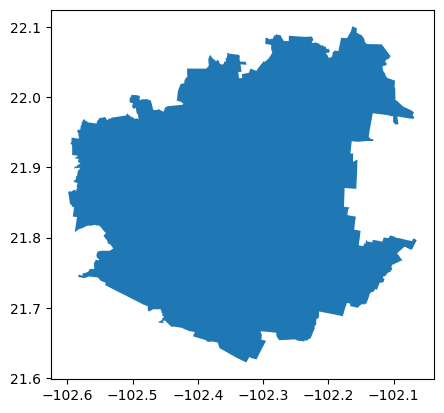

In [6]:
# --------------- CREATE AREA OF INTEREST (aoi)
# Downloads mun_gdf for city and create aoi
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mun_gdf = mun_gdf.set_crs("EPSG:4326")
aoi = mun_gdf.dissolve()

poly_wkt = aoi.dissolve().geometry.to_wkt()[0]

#Show
aoi.plot()

### Part 1.2 - Network

In [7]:
# --------------- CREATE NETWORK
# Network used to calculate nearest note to each poi
G, nodes, edges = aup.graph_from_hippo(aoi,'osmnx',edges_folder = edges_folder)

### Part 1.3 - Download points of interest

In [8]:
# --------------- DOWNLOAD POINTS OF INTEREST (clues and sip pois, not denue)
sip_clues = gpd.GeoDataFrame()

# CLUES (Salud)
# Download
#clues_gdf = aup.gdf_from_polygon(aoi, clues_schema, clues_table, geom_col="geometry")
query = f"SELECT * FROM {clues_schema}.{clues_table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
clues_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Filter
clues_pois = clues_gdf.loc[clues_gdf['nivel_atencion'] == 'PRIMER NIVEL']
del clues_gdf
# Format
clues_pois.loc[:,'code'] = 8610
clues_pois = clues_pois[['code','geometry']]
# Save to pois_tmp
sip_clues = pd.concat([sip_clues,clues_pois])
del clues_pois

print(f"Downloaded CLUES pois for {city}.")

# SIP (Marco geoestadistico)
# Download
#sip_gdf = aup.gdf_from_polygon(aoi, sip_schema, sip_table, geom_col="geometry")
query = f"SELECT * FROM {sip_schema}.{sip_table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
sip_gdf = aup.gdf_from_query(query, geometry_col='geometry')

sip_amenities = {'GEOGRAFICO':['Mercado','Plaza'], 
                 'TIPO':['Cancha','Unidad Deportiva','Áreas Verdes','Jardín','Parque']}
# Filter - SIP pois of interest
sip_amenities_codes = {'Mercado':4721, #sip_mercado
                       'Cancha':93110, #sip_cancha
                       'Unidad Deportiva':93111, #sip_unidad_deportiva 
                       'Áreas Verdes':9321, #sip_espacio_publico 
                       'Jardín':9321, #sip_espacio_publico
                       'Parque':9321, #sip_espacio_publico
                       'Plaza':9321 #sip_espacio_publico
                        }
# Filter - Iterate over sip_amenities and filter sip gdf
sip_pois = gpd.GeoDataFrame()
for col in sip_amenities:
    for amenity in sip_amenities[col]:
        sip_tmp = sip_gdf.loc[sip_gdf[col] == amenity]
        sip_tmp.loc[:,'code'] = sip_amenities_codes[amenity]
        sip_pois = pd.concat([sip_pois,sip_tmp])
del sip_gdf
# Format
sip_pois = sip_pois[['code','geometry']]
# Save to pois_tmp
sip_clues = pd.concat([sip_clues,sip_pois])
del sip_pois

print(f"Downloaded sip pois for {city}.")

Downloaded CLUES pois for Aguascalientes.
Downloaded sip pois for Aguascalientes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

### Part 1.4 - Points analysis

In [9]:
# --------------- ANALYSE POINTS OF INTEREST (for denue pois, downloads from db.)
i = 0
source_list = []

for eje in parameters.keys():
    for amenity in parameters[eje]:
        for source in parameters[eje][amenity]:
            print('--'*20)
            print(f'STARTING {source} for {city}.')
            source_list.append(source)
            
            # ANALYSIS - Select source points of interest
            source_pois = gpd.GeoDataFrame()
            for code in parameters[eje][amenity][source]:
                if source[0] == 'd': #denue
                    # Download
                    query = f"SELECT * FROM {denue_schema}.{denue_table} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')) AND (\"codigo_act\" = \'{code}\')"
                    code_pois = aup.gdf_from_query(query, geometry_col='geometry')
                    # Format
                    code_pois = code_pois[['codigo_act', 'geometry']]
                    code_pois = code_pois.rename(columns={'codigo_act':'code'})
                    code_pois['code'] = code_pois['code'].astype('int64')
                elif source[0] == 'c'or source[0] == 's': #clues or sip:
                    code_pois = sip_clues.loc[sip_clues['code'] == code]
                    print(f'Download sip/clues code {code} from pois_tmp.')
                else:
                    print(f'Error in parameters dicctionary.')
                    intended_crash
                    
                source_pois = pd.concat([source_pois,code_pois])

            print(f"Downloaded a total of {source_pois.shape[0]} pois for source amenity {source}.")
            
            # ANALYSIS - Calculate times from nodes to source
            print(len(source_pois))
            source_nodes_time = aup.pois_time(G, nodes, edges, source_pois, source, prox_measure)
            source_nodes_time.rename(columns={'time':source},inplace=True)
            source_nodes_time = source_nodes_time[['osmid',source,'x','y','geometry']]

            # ANALYSIS - Merge all times in one df
            if i == 0: # For the first analysed source
                nodes_analysis = source_nodes_time.copy()
            else: # For the rest
                nodes_analysis = pd.merge(nodes_analysis,source_nodes_time[['osmid',source]],on='osmid')

            i = i+1
        
        # Final format
        column_order = ['osmid'] + source_list + ['x','y','geometry']
        nodes_analysis = nodes_analysis[column_order]
        
        print(f'FINISHED nodes proximity analysis for {city}.')

----------------------------------------
STARTING denue_preescolar for Aguascalientes.
Downloaded a total of 306 pois for source amenity denue_preescolar.
306
Found and assigned nearest node osmid to each denue_preescolar.
Starting time analysis for denue_preescolar.
Starting range k = 1 of 2 for denue_preescolar.
Starting range k = 2 of 2 for denue_preescolar.
Finished time analysis for denue_preescolar.
FINISHED nodes proximity analysis for Aguascalientes.
----------------------------------------
STARTING denue_primaria for Aguascalientes.
Downloaded a total of 309 pois for source amenity denue_primaria.
309
Found and assigned nearest node osmid to each denue_primaria.
Starting time analysis for denue_primaria.
Starting range k = 1 of 2 for denue_primaria.
Starting range k = 2 of 2 for denue_primaria.
Finished time analysis for denue_primaria.
FINISHED nodes proximity analysis for Aguascalientes.
----------------------------------------
STARTING denue_secundaria for Aguascalientes.
D

In [10]:
print(nodes_analysis.shape)
nodes_analysis.head(1)

(51371, 34)


,osmid,denue_preescolar,denue_primaria,denue_secundaria,clues_primer_nivel,denue_guarderias,denue_dif,denue_supermercado,denue_abarrotes,denue_carnicerias,...,denue_cafe,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,denue_parque_natural,denue_cines,denue_museos,x,y,geometry
0,272921360,10.770629,5.615674,11.812107,6.486561,5.09561,6.486561,3.592175,1.673421,6.486561,...,5.25473,156.885198,28.44305,5.692959,NaN,26.069111,7.589368,-102.295073,21.872876,POINT (-102.29507 21.87288)


############################################################### PART 2 ###############################################################

### Part 2.1 - Fill for missing amenities

In [11]:
# Create definitions dicc out of main parameters dicc:
definitions = {}
for eje in parameters.keys():
    # Temporary dicc stores amenity:[source_list] for each eje
    tmp_dicc = {}
    
    for amenity in parameters[eje]:
        items_lst = []
        items = list(parameters[eje][amenity].items())
        
        for item in items:
            items_lst.append(item[0])
            
        tmp_dicc[amenity] = items_lst
     
    # Each eje gets assigned its own tmp_dicc
    definitions[eje] = tmp_dicc

In [12]:
#--------------- PREPARE DATA ---------- FILL MISSING COLUMNS (In case there is a source amenity not available in a city)
all_sources = []

# Gather all possible sources
for eje in definitions.keys():
    for amenity in definitions[eje].values():
        for source in amenity:
            all_sources.append(source)
            
# If source not in currently analized city, fill column with np.nan
column_list = list(nodes_analysis.columns)
missing_sourceamenities = []

for s in all_sources:
        if s not in column_list:
            nodes_analysis[s] = np.nan
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"{s} source amenity is not present in {city}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            missing_sourceamenities.append(s)
            
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Finished missing source amenities analysis. {len(missing_sourceamenities)} not present source amenities were added as np.nan columns")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Finished missing source amenities analysis. 0 not present source amenities were added as np.nan columns


### Part 2.2 - Amenities analysis

In [13]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Starting proximity to amenities analysis by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#--------------- PROCESS DATA 
#--------------- PROCESS DATA ---------- Max time calculation
#This step calculates times by amenity

column_max_all = [] # list with all max index column names
column_max_ejes = [] # list with ejes index column names

#Goes through each eje in dictionary:
for e in definitions.keys():

    #Appends to 3 lists currently examined eje
    column_max_all.append('max_'+ e.lower())
    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes through each amenity of current eje:
    for a in definitions[e].keys():

        #Appends to 2 lists currently examined amenity:
        column_max_all.append('max_'+ a.lower())
        column_max_amenities.append('max_'+ a.lower())

        #Calculates time to currently examined amenity:
        #If weight is less than number of sources of amenity, choose minimum time to sources.
        if source_weight[e][a] == 'min': 
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[definitions[e][a]].min(axis=1)
        #Else, choose maximum time to sources.
        else:
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[definitions[e][a]].max(axis=1)

    #Calculates time to currently examined eje (max time of its amenities):
    nodes_analysis['max_'+ e.lower()] = nodes_analysis[column_max_amenities].max(axis=1) 

index_column = 'max_time' # column name for maximum time data

#Add to column_max_all list the attribute 'max_time'
column_max_all.append(index_column)

#Assigns "max_time" the max time for all ejes
nodes_analysis[index_column] = nodes_analysis[column_max_ejes].max(axis=1)     

#Add to column_max_all list the attributes 'osmid' and 'geometry' to filter nodes_analysis with the column_max_all list.
column_max_all.append('osmid')
column_max_all.append('geometry')
nodes_analysis_filter = nodes_analysis[column_max_all].copy()
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Calculated proximity to amenities data by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Show
print(nodes_analysis_filter.shape)
nodes_analysis_filter.head(1)

Starting proximity to amenities analysis by node.
Calculated proximity to amenities data by node.
(51371, 21)


,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,max_comercio,max_alimentos,...,max_farmacias,max_hogar,max_complementarios,max_entretenimiento,max_social,max_actividad física,max_cultural,max_time,osmid,geometry
0,11.812107,10.770629,5.615674,11.812107,6.486561,6.486561,5.09561,6.486561,5.174683,1.673421,...,5.174683,4.743875,0.0,7.589368,5.25473,5.692959,7.589368,11.812107,272921360,POINT (-102.29507 21.87288)


### Part 2.3 - Population data

In [14]:
##### PARA INCLUIR MÁS RESOLUCIONES HAY QUE TRABAJAR CON ESTA PARTE.
res_list = [8]

# --------------- DOWNLOAD POP DATA
# Downloads hex_socio_gdf for city area
for res in res_list:
    query = f"SELECT * FROM {pop_schema}.{pop_table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
    hex_socio_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    hex_socio_gdf = hex_socio_gdf.set_crs("EPSG:4326")
    
    hex_socio_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_socio_gdf['res'] = res
    
    # Calculate density
    hex_socio_gdf_tmp = hex_socio_gdf.to_crs("EPSG:6372")
    hex_socio_gdf_tmp['dens_pob_ha'] = hex_socio_gdf_tmp['pobtot'] / (hex_socio_gdf_tmp.area / 10000)
    hex_socio_gdf_tmp = hex_socio_gdf_tmp[['hex_id','dens_pob_ha']]
    
    hex_socio_gdf = pd.merge(hex_socio_gdf,hex_socio_gdf_tmp,on='hex_id')

# Show
print(hex_socio_gdf.shape)
hex_socio_gdf.head(1)

(309, 227)


,geometry,hex_id,CVEGEO,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,res,dens_pob_ha
0,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",88498e36dbfffff,01001,264.7125,131.68126,133.03125,15.806251,7.65,8.15625,248.90625,...,36.225002,25.5375,18.393751,14.5125,0.61875,2.7,21.99375,0.3375,8,3.063433


In [15]:
hex_idx = gpd.GeoDataFrame()

for res in res_list:
    
    #/////////////////////////////////////////////////////////////////////////// HEXGRID DEPENDS ON POP DATA BEING CALCULATED OR NOT ///////////////////////////////////////////////////////////////////////////
    # If pop_output is true, loads previously created hexgrid with pop data
    if pop_output:
        # Load hexgrid
        hex_pop = hex_socio_gdf.loc[hex_socio_gdf['res'] == res]
        
        #Function group_by_hex_mean requires ID to include resolution
        hex_pop.rename(columns={'hex_id':f'hex_id_{res}'},inplace=True)
        
        # Create hex_tmp
        hex_pop = hex_pop.to_crs("EPSG:4326")
        hex_tmp = hex_pop[[f'hex_id_{res}','geometry']].copy()
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Loaded pop hexgrid of resolution {res}")
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        
    # If pop_output is false, creates hexgrid
    else:
        # Create hexgrid (which already has ID_res)
        hexgrid = aup.create_hexgrid(aoi,res)
        
        # Create hex_tmp
        hexgrid = hexgrid.set_crs("EPSG:4326")
        hex_tmp = hexgrid.copy()
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Created hexgrid of resolution {res}")
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        
    #/////////////////////////////////////////////////////////////////////////// HEXGRID DEPENDS ON POP DATA BEING CALCULATED OR NOT ///////////////////////////////////////////////////////////////////////////
    
    # group data by hex
    hex_res_idx = aup.group_by_hex_mean(nodes_analysis_filter, hex_tmp, res, index_column)
    hex_res_idx = hex_res_idx.loc[hex_res_idx[index_column]>0].copy()
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Grouped nodes data by hexagons res {res}")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    #////////////////////////////////////////////////////////////////////////////////// ADD POP DATA IF POP DATA IS CONSIDERED /////////////////////////////////////////////////////////////////////////////////
    # Add pop data
    if pop_output:
        pop_list = [f'hex_id_{res}','pobtot','dens_pob_ha']
        hex_res_pop = pd.merge(hex_res_idx, hex_pop[pop_list], on=f'hex_id_{res}')
    else:
        hex_res_pop = hex_res_idx.copy()
    #////////////////////////////////////////////////////////////////////////////////// ADD POP DATA IF POP DATA IS CONSIDERED /////////////////////////////////////////////////////////////////////////////////    
    
    # After funtion group_by_hex_mean we can remove res from ID and set as a column
    hex_res_pop.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_res_pop['res'] = res

    hex_idx = pd.concat([hex_idx,hex_res_pop])
        
    #-----------------------------------------------------------------------------------------------------------------------------------------------------    
    print(f"Saved grouped data by hexagons res {res}")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

Loaded pop hexgrid of resolution 8
Grouped nodes data by hexagons res 8
Saved grouped data by hexagons res 8


### Part 2.4 - Recalculate ejes max time by hexagon

In [16]:
#--------------- PROCESS DATA ---------- RE-CALCULATE MAX TIMES BY HEXAGON (ALL)
# This step recalculates max time to each eje from max times to calculated amenities and max_time from max eje
column_max_ejes = [] # list with ejes index column names

#Goes (again) through each eje in dictionary:
for e in definitions.keys():

    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes (again) through each amenity of current eje:    
    for a in definitions[e].keys():

        column_max_amenities.append('max_'+ a.lower())

    #Re-calculates time to currently examined eje (max time of its amenities):        
    hex_idx['max_'+ e.lower()] = hex_idx[column_max_amenities].max(axis=1)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished recalculating times in hexagons')
#-----------------------------------------------------------------------------------------------------------------------------------------------------   

Finished recalculating times in hexagons


### Part 2.5 - Calculate index and add aditional data

In [17]:
#--------------- PROCESS DATA ---------- INDEX, MEDIAN AND MEAN CALCULATION (ALL)

#Define function
def apply_sigmoidal(x):
    if x == -1:
        return -1
    elif x > 1000:
        return 0
    else:
        val = aup.sigmoidal_function(0.1464814753435666, x, 30)
        return val

#Apply function to amenities columns without ejes ---------------------------------------------///// En lugar de pasarle la lista de amenidades, se crea la lista de amenidades desde column_max_all
max_amenities_cols = [i for i in column_max_all if i not in column_max_ejes]
max_amenities_cols.remove('max_time')
max_amenities_cols.remove('osmid')
max_amenities_cols.remove('geometry')

idx_amenities_cols = [] # list with idx amenity column names
for ac in max_amenities_cols:
    idx_col = ac.replace('max','idx')
    hex_idx[idx_col] = hex_idx[ac].apply(apply_sigmoidal)
    idx_amenities_cols.append(idx_col)

# Add final data
hex_idx[index_column] = hex_idx[column_max_ejes].max(axis=1)
hex_idx['mean_time'] = hex_idx[max_amenities_cols].mean(axis=1)
hex_idx['median_time'] = hex_idx[max_amenities_cols].median(axis=1)
hex_idx['idx_sum'] = hex_idx[idx_amenities_cols].sum(axis=1)
hex_idx['city'] = city
#-----------------------------------------------------------------------------------------------------------------------------------------------------    
print('Finished calculating index, mean and median time')
#-----------------------------------------------------------------------------------------------------------------------------------------------------

Finished calculating index, mean and median time


### Part 2.6 - Final format

In [18]:
#--------------- FINAL FORMAT ----------
#--------------- FINAL FORMAT ---------- REORDER COLUMNS

# First elements of ordered list - ID and geometry
first_elements = ['hex_id','res','geometry']

# Second elements of ordered list - max_ejes and max_amenities removing max_time, osmid and geometry.
column_max_ejes_amenities = column_max_all.copy()
column_max_ejes_amenities.remove('max_time')
column_max_ejes_amenities.remove('osmid')
column_max_ejes_amenities.remove('geometry')

# Third elements of ordered list are listed in idx_amenities_cols

# Fourth elements of ordered list - Mean, median, max and idx
fourth_elements = ['mean_time', 'median_time', 'max_time', 'idx_sum']

# Fifth elements - If pop is calculated - Pop data
fifth_elements = ['pobtot', 'dens_pob_ha']

# Last element - City data
last_element = ['city']

if pop_output:
    final_column_ordered_list = first_elements + column_max_ejes_amenities + idx_amenities_cols + fourth_elements + fifth_elements + last_element
else:
    final_column_ordered_list = first_elements + column_max_ejes_amenities + idx_amenities_cols + fourth_elements + last_element
    
hex_idx_city = hex_idx[final_column_ordered_list]
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished final format')
#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Show
print(hex_idx_city.shape)
hex_idx_city.head(1)

Finished final format
(309, 42)


,hex_id,res,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,...,idx_social,idx_actividad física,idx_cultural,mean_time,median_time,max_time,idx_sum,pobtot,dens_pob_ha,city
0,88498e36dbfffff,8,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",15.057619,13.586498,15.057619,11.969535,62.167866,53.640209,50.912589,...,0.324113,0.854075,0.002455,28.977914,17.066295,71.010665,8.47822,264.7125,3.063433,Aguascalientes


In [19]:
hex_idx_city.to_file('../../data/external/temporal_fromjupyter/ags_proxanalysis_v2.gpkg', driver='GPKG')

## 02 - Result comparison

In [24]:
prox_schema = 'prox_analysis'
prox_table = 'time_15_min_analysis_hexres8'

query = f"SELECT * FROM {prox_schema}.{prox_table} WHERE \"city\" LIKE \'{city}\'"
original_prox_gdf = aup.gdf_from_query(query, geometry_col='geometry')

original_prox_gdf.rename(columns={'max_idx_15_min':'max_time',
                                  'dens_pobha':'dens_pob_ha'},inplace=True)

# Show
print(original_prox_gdf.shape)
original_prox_gdf.head(1)

(309, 30)


,hex_id_8,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_time,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pob_ha,city
0,88498e36dbfffff,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",15.057619,13.586498,15.057619,11.969535,62.167866,53.640209,50.912589,62.167866,...,71.010665,264.7125,131.68126,133.03125,75.9375,50.9625,117.731249,20.081251,3.063433,Aguascalientes


In [30]:
datos = column_max_ejes_amenities + ['max_time','pobtot','dens_pob_ha']

summarydata = pd.DataFrame()

i = 0

for c in datos:
    summarydata.loc[i,'columna'] = c
    summarydata.loc[i,'new_data'] = hex_idx_city[c].mean()
    summarydata.loc[i,'org_data'] = original_prox_gdf[c].mean()
    
    i = i+1

summarydata['diff'] = summarydata['org_data'] - summarydata['new_data']
    
summarydata

,columna,new_data,org_data,diff
0,max_escuelas,30.410337,30.410337,0.000000e+00
1,max_preescolar,19.174252,19.174252,0.000000e+00
2,max_primaria,19.586162,19.586162,0.000000e+00
3,max_secundaria,29.502061,29.502061,0.000000e+00
4,max_servicios comunitarios,51.221570,51.221570,0.000000e+00
5,max_salud,30.004489,30.004489,0.000000e+00
6,max_guarderías,24.394581,24.394581,0.000000e+00
7,max_asistencia social,48.149934,48.149934,0.000000e+00
8,max_comercio,22.000875,22.000875,0.000000e+00
9,max_alimentos,11.743858,11.743858,0.000000e+00
